# Домашнее задание №1

В этом домашнем задании вам предлагается обучить модель регрессии для предсказания стоимости автомобилей, а также реализовать веб-сервис для применения построенной модели на новых данных.

> Оценка за домашку = min(ваш балл, 10)


Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

<font color='#0000ff'>А синим цветом я выделила свои комментарии. </font>

In [208]:
from fastapi import FastAPI,  File, UploadFile
from fastapi.responses import StreamingResponse
from pydantic import BaseModel
from typing import List, Union, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re 
import warnings
import math
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

pd.options.display.float_format = '{:.4f}'.format


random.seed(42)
np.random.seed(42)

Ниже ответьте на вопрос <font color='#FF6600'>
"Для чего фиксируем сиды в домашках?"</font>

In [209]:
print("""Мы фиксируем сиды в домашках, чтобы результаты экспериментов, \
в которых присутствует фактор рандома, были воспроизводимы \
(т.е. чтобы проверяющий получал те же результаты)""")

Мы фиксируем сиды в домашках, чтобы результаты экспериментов, в которых присутствует фактор рандома, были воспроизводимы (т.е. чтобы проверяющий получал те же результаты)


# Часть 1 (2.5 балла + 0.75) | EDA

## Простейший EDA и обработка признаков (1.5 балла + 0.25)

In [210]:
df_train = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


(0.15 балла) <font color='#9933CC'>Отобразите 10 **случайных** строк тренировочного датасета</font>

In [211]:
np.random.seed(42)
df_train.sample(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6565,Renault KWID Climber 1.0 MT BSIV,2019,300000,35000,Petrol,Individual,Manual,First Owner,23.01 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0000
2943,Maruti Wagon R LXI,2013,225000,58343,Petrol,Trustmark Dealer,Manual,First Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0000
2024,Hyundai i20 Asta 1.2,2013,360000,30000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0000
263,Hyundai i20 1.2 Asta,2010,300000,70000,Petrol,Individual,Manual,First Owner,17.0 kmpl,1197 CC,80 bhp,"11.4 kgm at 4,000 rpm",5.0000
4586,Skoda Octavia L and K 1.9 TDI MT,2005,250000,120000,Diesel,Individual,Manual,Third Owner,16.4 kmpl,1896 CC,90 bhp,"21.4@ 1,900(kgm@ rpm)",5.0000
4479,Maruti Ciaz ZXi,2016,700000,20000,Petrol,Individual,Manual,First Owner,20.73 kmpl,1373 CC,91.1 bhp,130Nm@ 4000rpm,5.0000
4881,Hyundai Grand i10 1.2 Kappa Magna BSIV,2017,445000,27000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0000
3583,Ford Ecosport 1.5 DV5 MT Trend,2016,515000,68609,Diesel,Dealer,Manual,First Owner,22.7 kmpl,1498 CC,89.84 bhp,204Nm@ 2000-2750rpm,5.0000
6361,Hyundai Verna 1.4 VTVT,2014,500000,33400,Petrol,Individual,Manual,First Owner,17.43 kmpl,1396 CC,105.5 bhp,135.3Nm@ 5000rpm,5.0000
4108,Hyundai i20 Era 1.2,2015,490000,45900,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0000


(0.1 балла) <font color='#9933CC'>Отобразите первые 5 и последние 5 объектов тестового датасета</font>

In [212]:
df_test.head() # первые 5

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0000
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0000
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0000
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0000
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0000


In [213]:
df_test.tail() # последние 5

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0000
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0000
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0000
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0000
999,Honda City i DTec SV,2016,700000,110000,Diesel,Individual,Manual,First Owner,26.0 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0000


(0.1 балла) <font color='#9933CC'>Посчитайте основные статистики как по числовым, так и по категориальным столбцам для трейна и теста</font>. 
> Подсказка: ``.describe()`` с нужным(и) аргументом(-ами)



In [214]:
df_train.describe()  # по числовым

,year,selling_price,km_driven,seats
count,6999.0000,6999.0000,6999.0000,6797.0000
mean,2013.8184,639515.1972,69584.6155,5.4190
std,4.0531,808941.9119,57724.0018,0.9658
min,1983.0000,29999.0000,1.0000,2.0000
25%,2011.0000,254999.0000,35000.0000,5.0000
50%,2015.0000,450000.0000,60000.0000,5.0000
75%,2017.0000,675000.0000,97000.0000,5.0000
max,2020.0000,10000000.0000,2360457.0000,14.0000


In [215]:
df_test.describe() 

,year,selling_price,km_driven,seats
count,1000.0000,1000.0000,1000.0000,981.0000
mean,2013.6810,617901.0420,71393.3410,5.4108
std,4.0121,758553.8607,48486.2187,0.9200
min,1995.0000,31000.0000,1303.0000,4.0000
25%,2011.0000,250000.0000,37000.0000,5.0000
50%,2014.0000,434999.0000,61500.0000,5.0000
75%,2017.0000,670000.0000,100000.0000,5.0000
max,2020.0000,6000000.0000,375000.0000,9.0000


In [216]:
df_train.describe(include = 'object') # категориальные

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803,6796
unique,1924,4,3,2,5,386,120,316,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330,468


In [217]:
df_test.describe(include = 'object')

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


(0.15 балла) <font color='#9933CC'>Посмотрите, есть ли в датасете пропуски.</font>

<font color='#FF6600'>Если есть, то в каких колонках?</font>

In [218]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [219]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1000 non-null   object 
 1   year           1000 non-null   int64  
 2   selling_price  1000 non-null   int64  
 3   km_driven      1000 non-null   int64  
 4   fuel           1000 non-null   object 
 5   seller_type    1000 non-null   object 
 6   transmission   1000 non-null   object 
 7   owner          1000 non-null   object 
 8   mileage        981 non-null    object 
 9   engine         981 non-null    object 
 10  max_power      981 non-null    object 
 11  torque         981 non-null    object 
 12  seats          981 non-null    float64
dtypes: float64(1), int64(3), object(9)
memory usage: 101.7+ KB


> <font color='#0000ff'>Пропуски есть в колонках  ``mileage, engine, max_power, torque , seats  `` </font>

(0.1 балла) <font color='#9933CC'>Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием</font> (целевую переменную следует исключить). Если есть, то сколько?

In [220]:
df_train[df_train.duplicated(subset = set(df_train.columns) - {'selling_price'})].shape

(1159, 13)

> <font color='#0000ff'>1159 объектов</font>

(0.15 балла) <font color='#9933CC'>Отобразите такие объекты</font>

In [221]:
df_train[df_train.duplicated(subset = set(df_train.columns) - {'selling_price'})]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0000
258,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0000
268,Maruti Swift Dzire VXI,2014,400000,70000,Petrol,Individual,Manual,Second Owner,19.1 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0000
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0000
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,Chevrolet Spark 1.0 LS,2010,140000,60000,Petrol,Individual,Manual,Second Owner,18.0 kmpl,995 CC,62 bhp,90.3Nm@ 4200rpm,5.0000
6984,Ford Freestyle Titanium Plus Diesel BSIV,2018,746000,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63 bhp,215Nm@ 1750-3000rpm,5.0000
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0000
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0000


(0.15 балла) <font color='#9933CC'>Удалите повторяющиеся строки</font>. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю

> <font color='#0000ff'>По умолчанию duplicated считает дублями все повторяющиеся значения, кроме первого (параметр keep со значением по умолчанию False), поэтому это как раз то, что нужно:</font>

In [222]:
df_train = df_train[~df_train.duplicated(subset = set(df_train.columns) - {'selling_price'})] 

In [225]:
assert df_train.shape == (5840, 13)

(0.1 балла) Чтоб все было по красоте, <font color='#9933CC'>обновите индексы строк таким образом, чтобы они шли от 0 без пропусков</font>

In [227]:
df_train.reset_index(drop=True, inplace=True)

In [228]:
df_train.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1 bhp,96.1Nm@ 3000rpm,5.0000
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0000
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0000
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0000
5839,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0000


Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не слава богу. Давайте починим.

(0.25 балла) Задача такая: 
<font color='#9933CC'>
* убрать единицы измерения для признаков ``mileage, engine, max_power``. 
* кастануть эти столбцы столбцы к ``float``.
* удалить столбец ``torque``
</font>

> Все действия нужно производить над обоими датасетами

---
**Доп (0.25 балла):**
* <font color='#9933CC'>Вместо удаления признак `torque` разделите на два: собственно `torque` и `max_torque_rpm`.</font> Учтите единицы измерения. Они разные ☹

#### <font color='#0000ff'>столбцы   ``mileage, engine, max_power``</font>

In [229]:
def str_to_float(st):
    if isinstance(st, float):
        return st
    num = re.findall('\d+[.,]?\d*', st)
    if len(num) == 0:
        return np.nan
    else:
        return float(num[0])


In [230]:
for col in ('mileage', 'engine', 'max_power'):
    df_train[f'{col}'] = df_train[col].apply(str_to_float)
    df_test[f'{col}'] = df_test[col].apply(str_to_float)

In [231]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4000,1248.0000,74.0000,190Nm@ 2000rpm,5.0000
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.1400,1498.0000,103.5200,250Nm@ 1500-2500rpm,5.0000
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0000,1396.0000,90.0000,22.4 kgm at 1750-2750rpm,5.0000
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1000,1298.0000,88.2000,"11.5@ 4,500(kgm@ rpm)",5.0000
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.1400,1197.0000,81.8600,113.75nm@ 4000rpm,5.0000


#### <font color='#0000ff'>~Страдаем ради 0.25~ разделяем  `torque` и `max_torque_rpm`</font>

 <font color='#0000ff'>Посмотрим на данные с одним @:</font>


In [232]:
for t in pd.concat([df_train, df_test])['torque']:
    if isinstance(t, str) and len(t.split('@')) == 2:
        print(t)

190Nm@ 2000rpm
250Nm@ 1500-2500rpm
113.75nm@ 4000rpm
59Nm@ 2500rpm
170Nm@ 1800-2400rpm
160Nm@ 2000rpm
248Nm@ 2250rpm
78Nm@ 4500rpm
190Nm@ 2000rpm
84Nm@ 3500rpm
115Nm@ 3500-3600rpm
62Nm@ 3000rpm
219.7Nm@ 1500-2750rpm
160Nm@ 2000rpm
200Nm@ 1750rpm
190Nm@ 2000rpm
200Nm@ 1750rpm
115Nm@ 4000rpm
69Nm@ 3500rpm
172.5Nm@ 1750rpm
84Nm@ 3500rpm
59Nm@ 2500rpm
200Nm@ 1750rpm
6.1kgm@ 3000rpm
200Nm@ 1750rpm
60Nm@ 3500rpm
90Nm@ 3500rpm
151Nm@ 4850rpm
104Nm@ 4000rpm
320Nm@ 1700-2700rpm
59Nm@ 2500rpm
250Nm@ 1750-2500rpm
145Nm@ 4600rpm
146Nm@ 4800rpm
200Nm@ 1750rpm
90Nm@ 3500rpm
343Nm@ 1400-3400rpm
200Nm@ 1400-3400rpm
200Nm@ 1250-4000rpm
200Nm@ 1750rpm
400Nm@ 2000-2500rpm
200Nm@ 1750rpm
200Nm@ 1750rpm
360Nm@ 1200-3400rpm
200Nm@ 1200-3600rpm
380Nm@ 1750-2500rpm
400Nm@ 1750-3000rpm
400Nm@ 1400-2800rpm
200Nm@ 1750-3000rpm
111.7Nm@ 4000rpm
219.6Nm@ 1500-2750rpm
190Nm@ 2000rpm
112Nm@ 4000rpm
115Nm@ 4000rpm
250Nm@ 1500-3000rpm
200Nm@ 1750rpm
90Nm@ 3500rpm
250Nm@ 1500-3000rpm
200Nm@ 1750rpm
190Nm@ 2000rpm
343Nm

 <font color='#0000ff'>Проверим, есть ли данные, которые не строки, а также данные без `@` или более чем с одним `@`: <font color='#0000ff'>

In [233]:
for t in pd.concat([df_train, df_test])['torque']:
    if not isinstance(t, str):
        print(f'!!!{type(t)}:  {t}')
    elif len(t.split('@')) != 2:
        print(t)

22.4 kgm at 1750-2750rpm
11.5@ 4,500(kgm@ rpm)
7.8@ 4,500(kgm@ rpm)
!!!<class 'float'>:  nan
22.4 kgm at 1750-2750rpm
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
400Nm
250 Nm at 2750 rpm
146Nm at 4800 rpm
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
11.4 kgm at 4,000 rpm
!!!<class 'float'>:  nan
12.5@ 3,500(kgm@ rpm)
11.8@ 3,200(kgm@ rpm)
11.4 kgm at 4,000 rpm
!!!<class 'float'>:  nan
20.4@ 1400-3400(kgm@ rpm)
180 Nm at 1440-1500rpm
11.4 kgm at 4,000 rpm
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
11.5@ 4,500(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
!!!<class 'float'>:  nan
20.4@ 1400-3400(kgm@ rpm)
!!!<class 'float'>:  nan
20.4@ 1400-3400(kgm@ rpm)
24@ 1,900-2,750(kgm@ rpm)
13.5@ 2,500(kgm@ rpm)
400Nm
20.4@ 1400-3400(kgm@ rpm)
135 Nm at 2500  rpm 
24 KGM at 1900-2750 RPM
14.3@ 1,800-3,000(kgm@ rpm)
8.5@ 2,500(kgm@ rpm)
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
!!!<class 'float'>:  nan
180 Nm

 <font color='#0000ff'>Теперь уберем cлучаи с  `at`:  </font>

In [234]:
for t in pd.concat([df_train, df_test])['torque']:
    if isinstance(t, str) and len(t.split('@')) != 2 and len(t.split('at')) != 2:
        print(t)

11.5@ 4,500(kgm@ rpm)
7.8@ 4,500(kgm@ rpm)
400Nm
12.5@ 3,500(kgm@ rpm)
11.8@ 3,200(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
11.5@ 4,500(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
24@ 1,900-2,750(kgm@ rpm)
13.5@ 2,500(kgm@ rpm)
400Nm
20.4@ 1400-3400(kgm@ rpm)
14.3@ 1,800-3,000(kgm@ rpm)
8.5@ 2,500(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
115@ 2,500(kgm@ rpm)
9.8@ 3,000(kgm@ rpm)
24@ 1,900-2,750(kgm@ rpm)
12.5@ 3,500(kgm@ rpm)
13@ 2,500(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
12.7@ 2,700(kgm@ rpm)
9.8@ 3,000(kgm@ rpm)
16.3@ 2,000(kgm@ rpm)
12@ 3,500(kgm@ rpm)
13.5@ 2,500(kgm@ rpm)
16@ 2,000(kgm@ rpm)
12.7@ 2,700(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
24@ 1,900-2,750(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
13.5@ 2,500(kgm@ rpm)
14.9@ 3,000(kgm@ rpm)
16.3@ 2,000(kgm@ rpm)
13@ 2,500(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
20.4@ 1400-3400(kgm@ rpm)
19@ 1,800(kgm@ rpm)
8.5@ 2,500(kgm@ rpm)
9.2@ 4,200(kgm@ rpm)
145@ 4,100(kgm@ rpm)
12.5@ 2,500(kgm@ rpm)
20.4@ 1400-3400(kgm@

 <font color='#0000ff'> Уберем случаи с `kgm@ rpm` или `NM@ rpm`:  </font>

In [235]:
for t in pd.concat([df_train, df_test])['torque']:
    if isinstance(t, str) and len(t.split('@')) != 2 and len(t.split('at')) != 2 and 'kgm@ rpm' not in t and 'NM@ rpm' not in t:
        print(t)

400Nm
400Nm
400 Nm /2000 rpm
210 / 1900
210 / 1900
210 / 1900
210 / 1900
210 / 1900
210 / 1900
210 / 1900
400Nm
400Nm
400Nm
400Nm
480Nm


 <font color='#0000ff'> Отдельно посмотрим на варианты с `+/-`:  </font>

In [236]:
for t in pd.concat([df_train, df_test])['torque']:
    if isinstance(t, str) and ('+-'  in t or '+/-' in t):
        print(t)

51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm
48@ 3,000+/-500(NM@ rpm)
51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm
48@ 3,000+/-500(NM@ rpm)
51Nm@ 4000+/-500rpm
51Nm@ 4000+/-500rpm


 <font color='#0000ff'>**Итак, получаем следующие варианты построения строки и вариантов преобразования её в два признака:</font>**
1. `NaN`. В этом случае `torque` и `max_torque_rpm` будут равны `NaN`
2. `torque` и `max_torque_rpm`  разделены знаком `@`. В этом случае  `torque` будет равно числу слева от `@`, а  `max_torque_rpm` - правому из чисел справа от `@` (случай, когда диапазон указан через `+/-`, обрабатывается отдельно)
3.  `torque` и `max_torque_rpm`  разделены предлогом `at`. В этом случае  `torque` будет равно числу слева от `at`, а  `max_torque_rpm` - правому из чисел справа от `at` (случай, когда диапазон указан через `+/-`, обрабатывается отдельно).
4. `torque` и `max_torque_rpm`  разделены знаком `@`, но при этом в данных есть подстрока  `kgm@ rpm` или `NM rpm`. В этом случае  `torque` будет равно числу слева от первого `@`, а  `max_torque_rpm` - правому из чисел справа от первого `@` (случай, когда диапазон указан через `+/-`, обрабатывается отдельно).
5. Указано только `torque` (например, `480Nm`). В этом случае `torque` будет равно соответствующему числу, а `max_torque_rpm` будут равно `NaN`.
6.   `torque` и `max_torque_rpm`  разделены `/`. В этом случае  `torque` будет равно числу слева от `/`, а  `max_torque_rpm` - правому из чисел справа от `/` (здесь случаев, когда диапазон указан через `+/-`, вроде нет, но давайте представим, что мы хотим предусмотреть некоторые новые возможные случаи в новых данных) 

In [237]:
def divide_torque(torque):
    try:
        if not isinstance(torque, str): #case 1
            final_torque, final_max_torque_rmp = torque, torque
        else:
            torque_split = torque.split('@')
            torque_split_at = torque.split('at')
            torque_split_sl = torque.split('/')
            if len(torque_split) == 2 or len(torque_split) == 3 or len(torque_split_at) == 2 or len(torque_split_sl) == 2: #cases 2, 3, 4, 6
                if len(torque_split) == 2:
                    left, right = torque_split
                elif len(torque_split) == 3:
                    left, right = torque_split[0],  torque_split[1]
                elif len(torque_split_at) == 2:
                    left, right = torque_split_at
                else:
                    left, right = torque_split_sl
                if '+/-' in right:
                    num, interval = re.findall('\d+[.,]?\d*', right)
                    if interval.find(',' ) != -1:
                        interval = interval.replace(',', '')
                    if num.find(',' ) != -1:
                        num = num.replace(',', '')
                    final_max_torque_rmp = float(num) + float(interval) 
                else:
                    num = re.findall('\d+[.,]?\d*', right)[-1]
                    if num.find(',' ) != -1:
                        num = num.replace(',', '')
                    final_max_torque_rmp = float(num)
                num = re.findall('\d+[.,]?\d*', left)[0]
                if num.find(',' ) != -1:
                    num = num.replace(',', '.')
                final_torque = float(num)
            elif len(torque_split) == 1 or len(torque_split) == 1 or len(torque_split_at) == 1 or len(torque_split_sl) == 1: # case 5
                num = re.findall('\d+[.,]?\d*', torque)[0]
                if num.find(',' ) != -1:
                    num = num.replace(',', '.')
                final_torque, final_max_torque_rmp = float(num), np.nan
            else:
                print('!', torque_split, torque_split_at, torque_split_sl)
                final_torque, final_max_torque_rmp = np.nan, np.nan
                warnings.warn(f'Unexpected line structure: {torque}. Returned empty value')
    except:
        final_torque, final_max_torque_rmp = np.nan, np.nan
        warnings.warn(f'Unexpected line structure: {torque}. Returned empty value')
    finally:
        return final_torque, final_max_torque_rmp 

 <font color='#0000ff'>Примеры работы функции:</font>

In [241]:
for example in ('480Nm', '140Nm@ 1800-3000rpm', '190Nm@ 2000rpm', '22.4 kgm at 1750-2750rpm', 
                '20.4@ 1400-3400(kgm@ rpm)', '250 Nm at 2750 rpm', '400 Nm /2000 rpm', 
               '48@ 3,000+/-500(NM@ rpm)', '51Nm@ 4000+/-500rpm', 
               '210 / 1900', '12.5@ 2,500(kgm@ rpm)',  '6@ 2,500(kgm@ rpm'):
    print(f'{example}:   {divide_torque(example)}')

480Nm:   (480.0, nan)
140Nm@ 1800-3000rpm:   (140.0, 3000.0)
190Nm@ 2000rpm:   (190.0, 2000.0)
22.4 kgm at 1750-2750rpm:   (22.4, 2750.0)
20.4@ 1400-3400(kgm@ rpm):   (20.4, 3400.0)
250 Nm at 2750 rpm:   (250.0, 2750.0)
400 Nm /2000 rpm:   (400.0, 2000.0)
48@ 3,000+/-500(NM@ rpm):   (48.0, 3500.0)
51Nm@ 4000+/-500rpm:   (51.0, 4500.0)
210 / 1900:   (210.0, 1900.0)
12.5@ 2,500(kgm@ rpm):   (12.5, 2500.0)
6@ 2,500(kgm@ rpm:   (6.0, 2500.0)


In [242]:
df_train['tmp_torque'] = df_train['torque'].apply(divide_torque)
df_train['torque'] = df_train['tmp_torque'].apply(lambda x: x[0])
df_train['max_torque_rpm'] = df_train['tmp_torque'].apply(lambda x: x[1])
df_train = df_train.drop('tmp_torque', axis=1)

df_test['tmp_torque'] = df_test['torque'].apply(divide_torque)
df_test['torque'] = df_test['tmp_torque'].apply(lambda x: x[0])
df_test['max_torque_rpm'] = df_test['tmp_torque'].apply(lambda x: x[1])
df_test = df_test.drop('tmp_torque', axis=1)

 <font color='#0000ff'>Warning-ов нет, значит, мы всё сделали правильно. </font>

(0.15 балла) <font color='#9933CC'>Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось</font>

> Обратите внимание, что, по уму, нужно посчитать медиану по трейну и этим средним заполнять пропуски в тесте. Так же делаем, если, например, стандартизируем признаки.



In [243]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5654 non-null   float64
 9   engine          5654 non-null   float64
 10  max_power       5656 non-null   float64
 11  torque          5653 non-null   float64
 12  seats           5654 non-null   float64
 13  max_torque_rpm  5653 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


In [244]:
for column in ('mileage', 'engine', 'max_power', 'torque' , 'max_torque_rpm', 'seats'):
    train_median = df_train[column].median()
    df_train[column] = df_train[column].fillna(train_median)
    df_test[column] = df_test[column].fillna(train_median)

 <font color='#0000ff'>Убедимся, что пропусков больше нет: </font>

In [245]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   float64
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   float64
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


In [246]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   year            1000 non-null   int64  
 2   selling_price   1000 non-null   int64  
 3   km_driven       1000 non-null   int64  
 4   fuel            1000 non-null   object 
 5   seller_type     1000 non-null   object 
 6   transmission    1000 non-null   object 
 7   owner           1000 non-null   object 
 8   mileage         1000 non-null   float64
 9   engine          1000 non-null   float64
 10  max_power       1000 non-null   float64
 11  torque          1000 non-null   float64
 12  seats           1000 non-null   float64
 13  max_torque_rpm  1000 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 109.5+ KB



(0.1 балла) Теперь, когда не осталось пропусков, можно <font color='#9933CC'>преобразовать столбцы к более подходящим типам (``engnine`` и ``seats`` к int)
</font>

Ниже ответьте, <font color='#FF6600'>почему (хоть мы этого и не делаем) ``seats``, возможно, лучше сделать переменной категориальной, а не целочисленной.</font>

<Axes: xlabel='seats', ylabel='selling_price'>

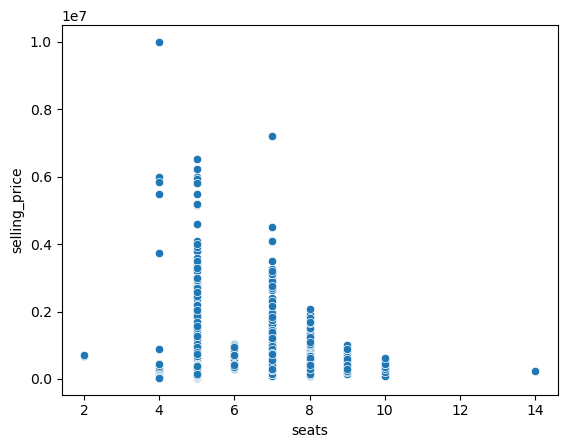

In [247]:
sns.scatterplot(df_train, x = 'seats', y = 'selling_price')

In [248]:
print(df_train['seats'].unique())

[ 5.  4.  7.  8.  6.  9. 10. 14.  2.]


In [249]:
print("Видим, что у нас всего 9 уникальных значений переменной,\
 и при этом целевая переменная зависит от нее нелинейно. \
Скорее всего, использование её как числового признака не улучшит качество модели.")

Видим, что у нас всего 9 уникальных значений переменной, и при этом целевая переменная зависит от нее нелинейно. Скорее всего, использование её как числового признака не улучшит качество модели.


In [250]:
df_train['engine'] = df_train['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)

## Визуализации (1 балл + 0.5)

Визуализировать нам надо не так уж и много. Во-первых, хотелось бы, в принципе, увидеть как распределены значения признаков. Также хотелось бы понять, насколько признаки скоррелированы между собой и с целевой переменной. А ещё неплохо бы посмотреть, не оказалось ли так, что тестовые данные распределены иначе, чем трейн.

Этим всем и предлагаем вам заняться.

(0.25 балла) <font color='#9933CC'>Посторойте попарные распределения всех числовых признаков для трейна.</font>

> ``sns.paiplot()`` позволяет сделать это в одну строчку

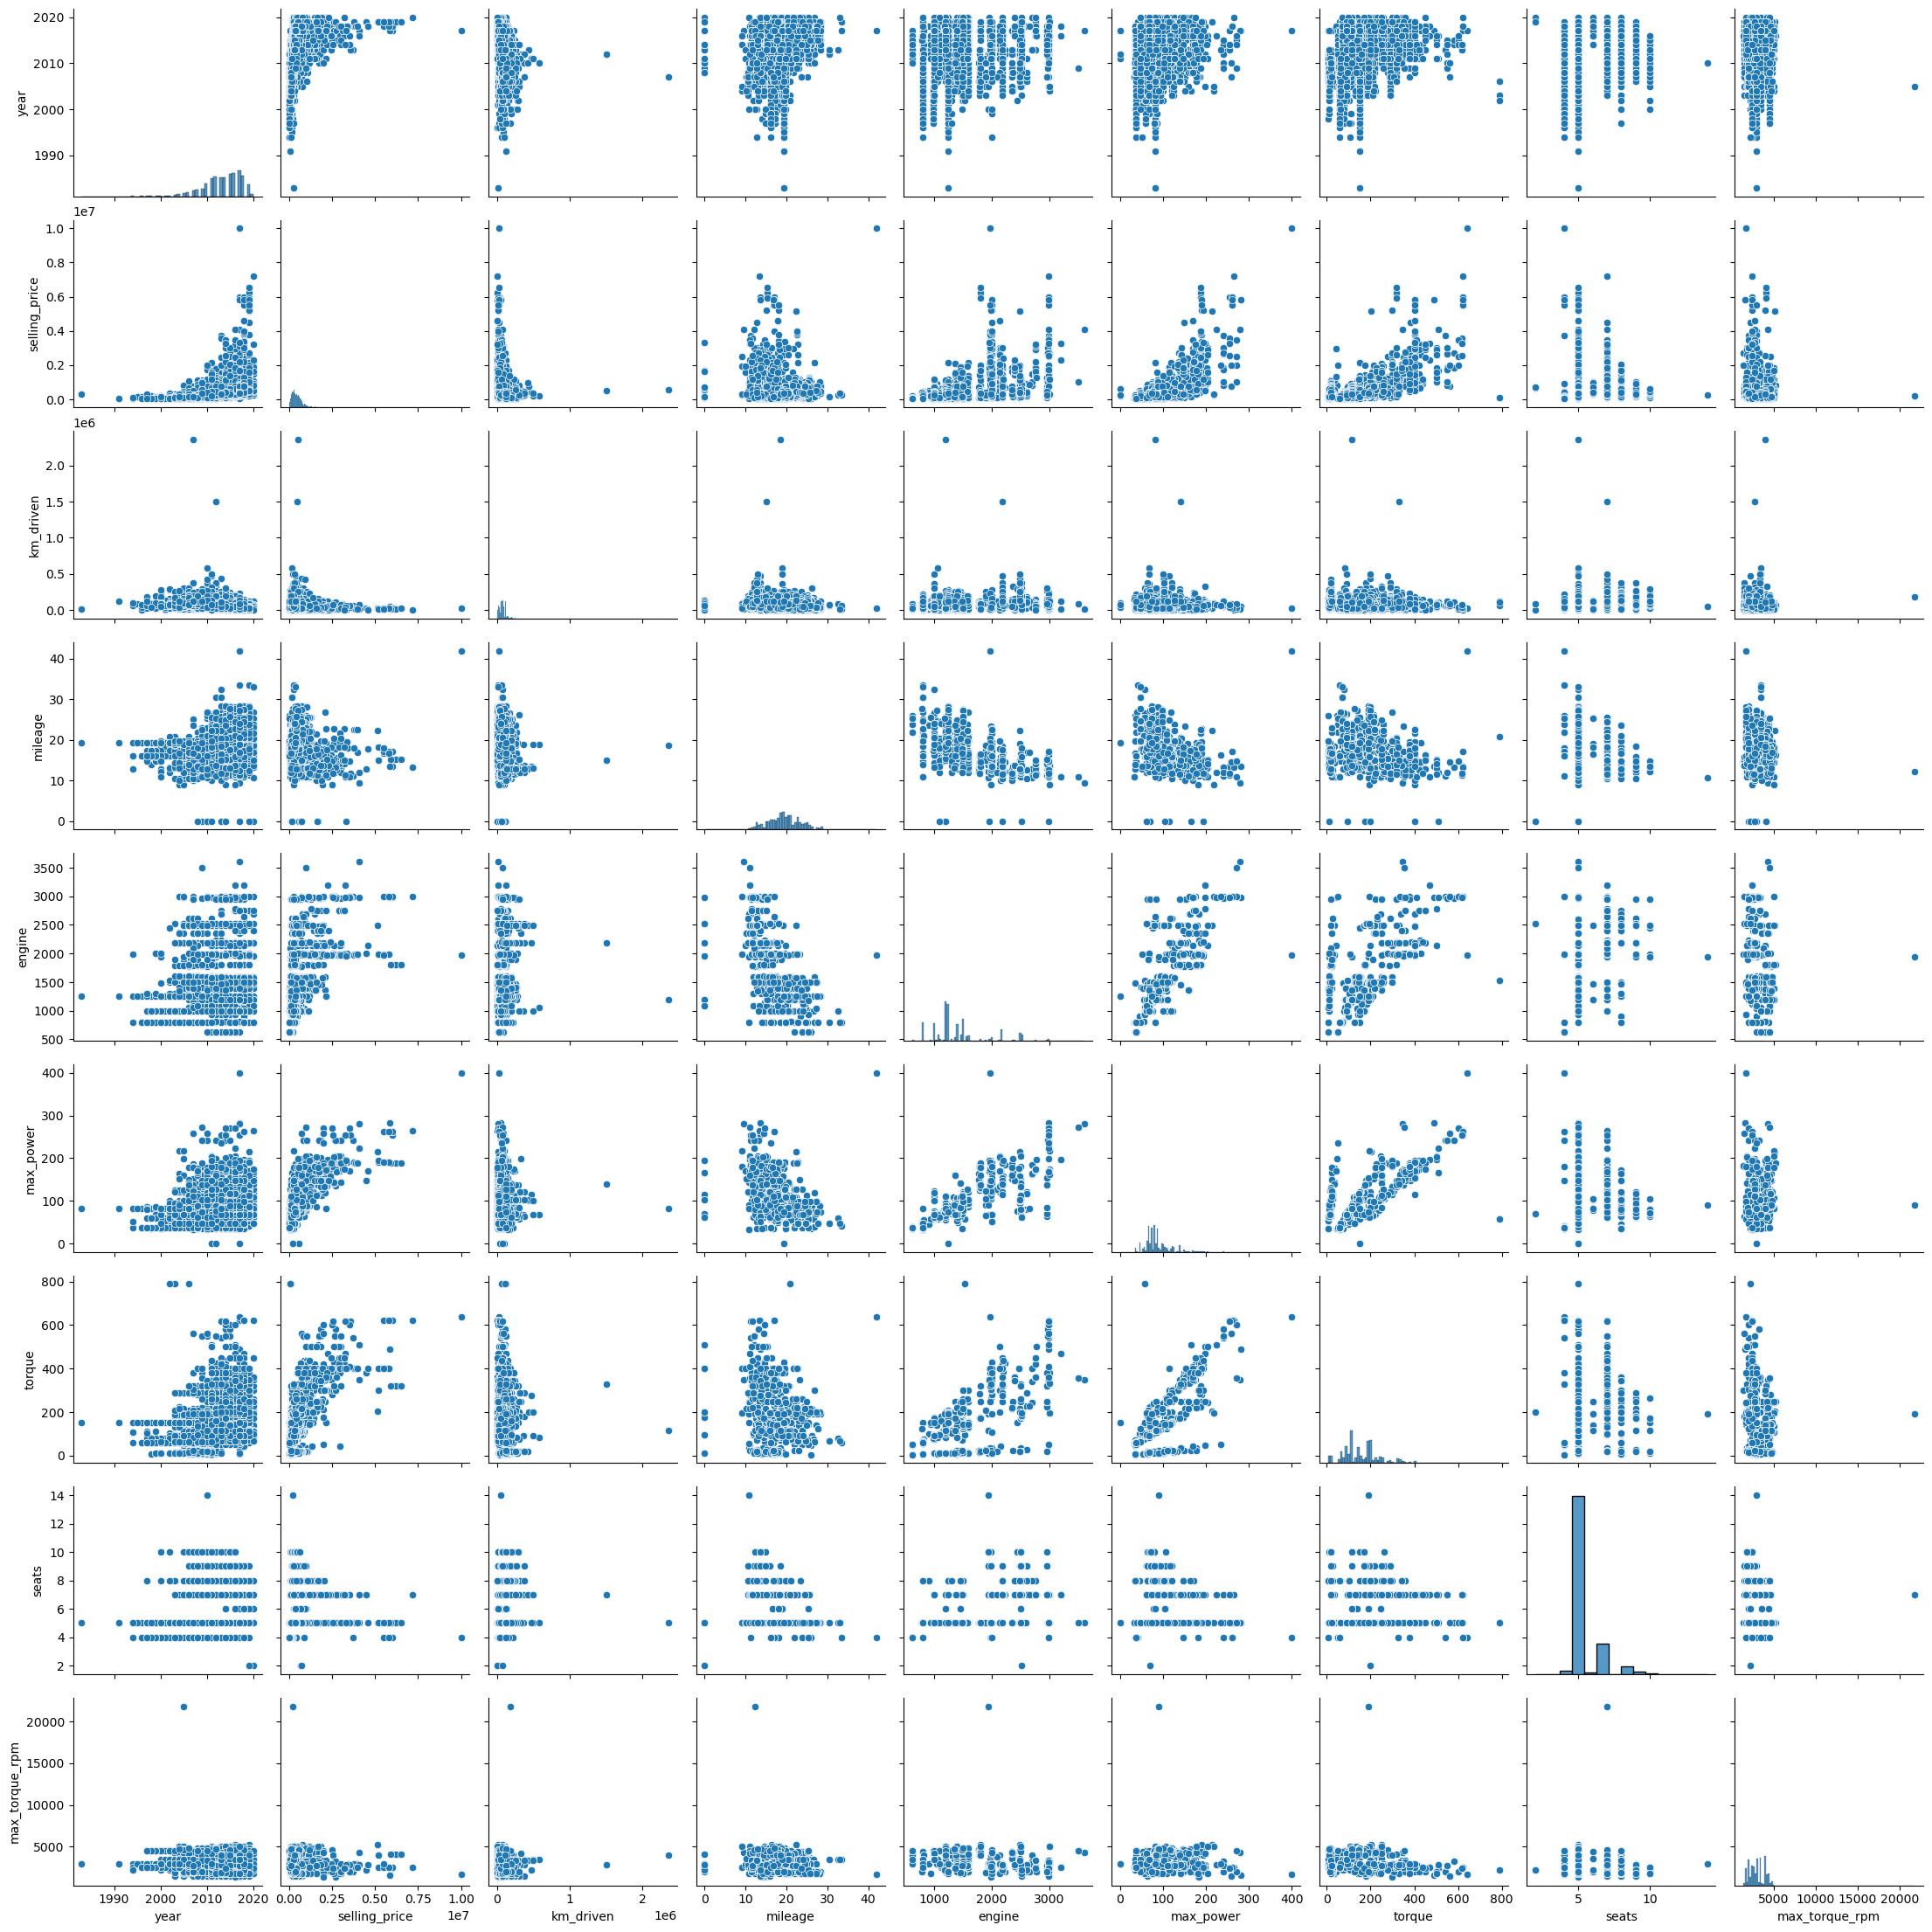

In [81]:
sns.pairplot(df_train)

Этот график не такой информативный, как можно было бы построить, беря признаки по отдельности. Но он позволяет сделать некоторые (возможно, далеко идущие) выводы. Впрочем, со многими из них (если не со всеми) вы бы справились умозрительно. Однако всегда приятно делать выводы, основываясь на данных.



* <font color='#FF6600'> Что можно сказать о связи предикторов с целевой переменной?
* А о корреляциях признаков? </font>

>  <font color='#0000ff'>Видно, что прослеживается корреляция целевой переменной `selling_price` c признаками ``max_power, torque, engine``  </font>

>  <font color='#0000ff'>Видна отрицательная линейная связь между `mileage` и `engine`, положительная линейная связь признака `engine` с каждым из признаков `torque`, `max_power`, а также положительная линейная свящь между `max_power` и `torque`. </font>

(0.25 балла) <font color='#9933CC'>Постройте pairplot по тестовым данным</font> и ответьте на вопрос <font color='#FF6600'>"Похожими ли оказались совокупности при разделении на трейн и тест?"</font>

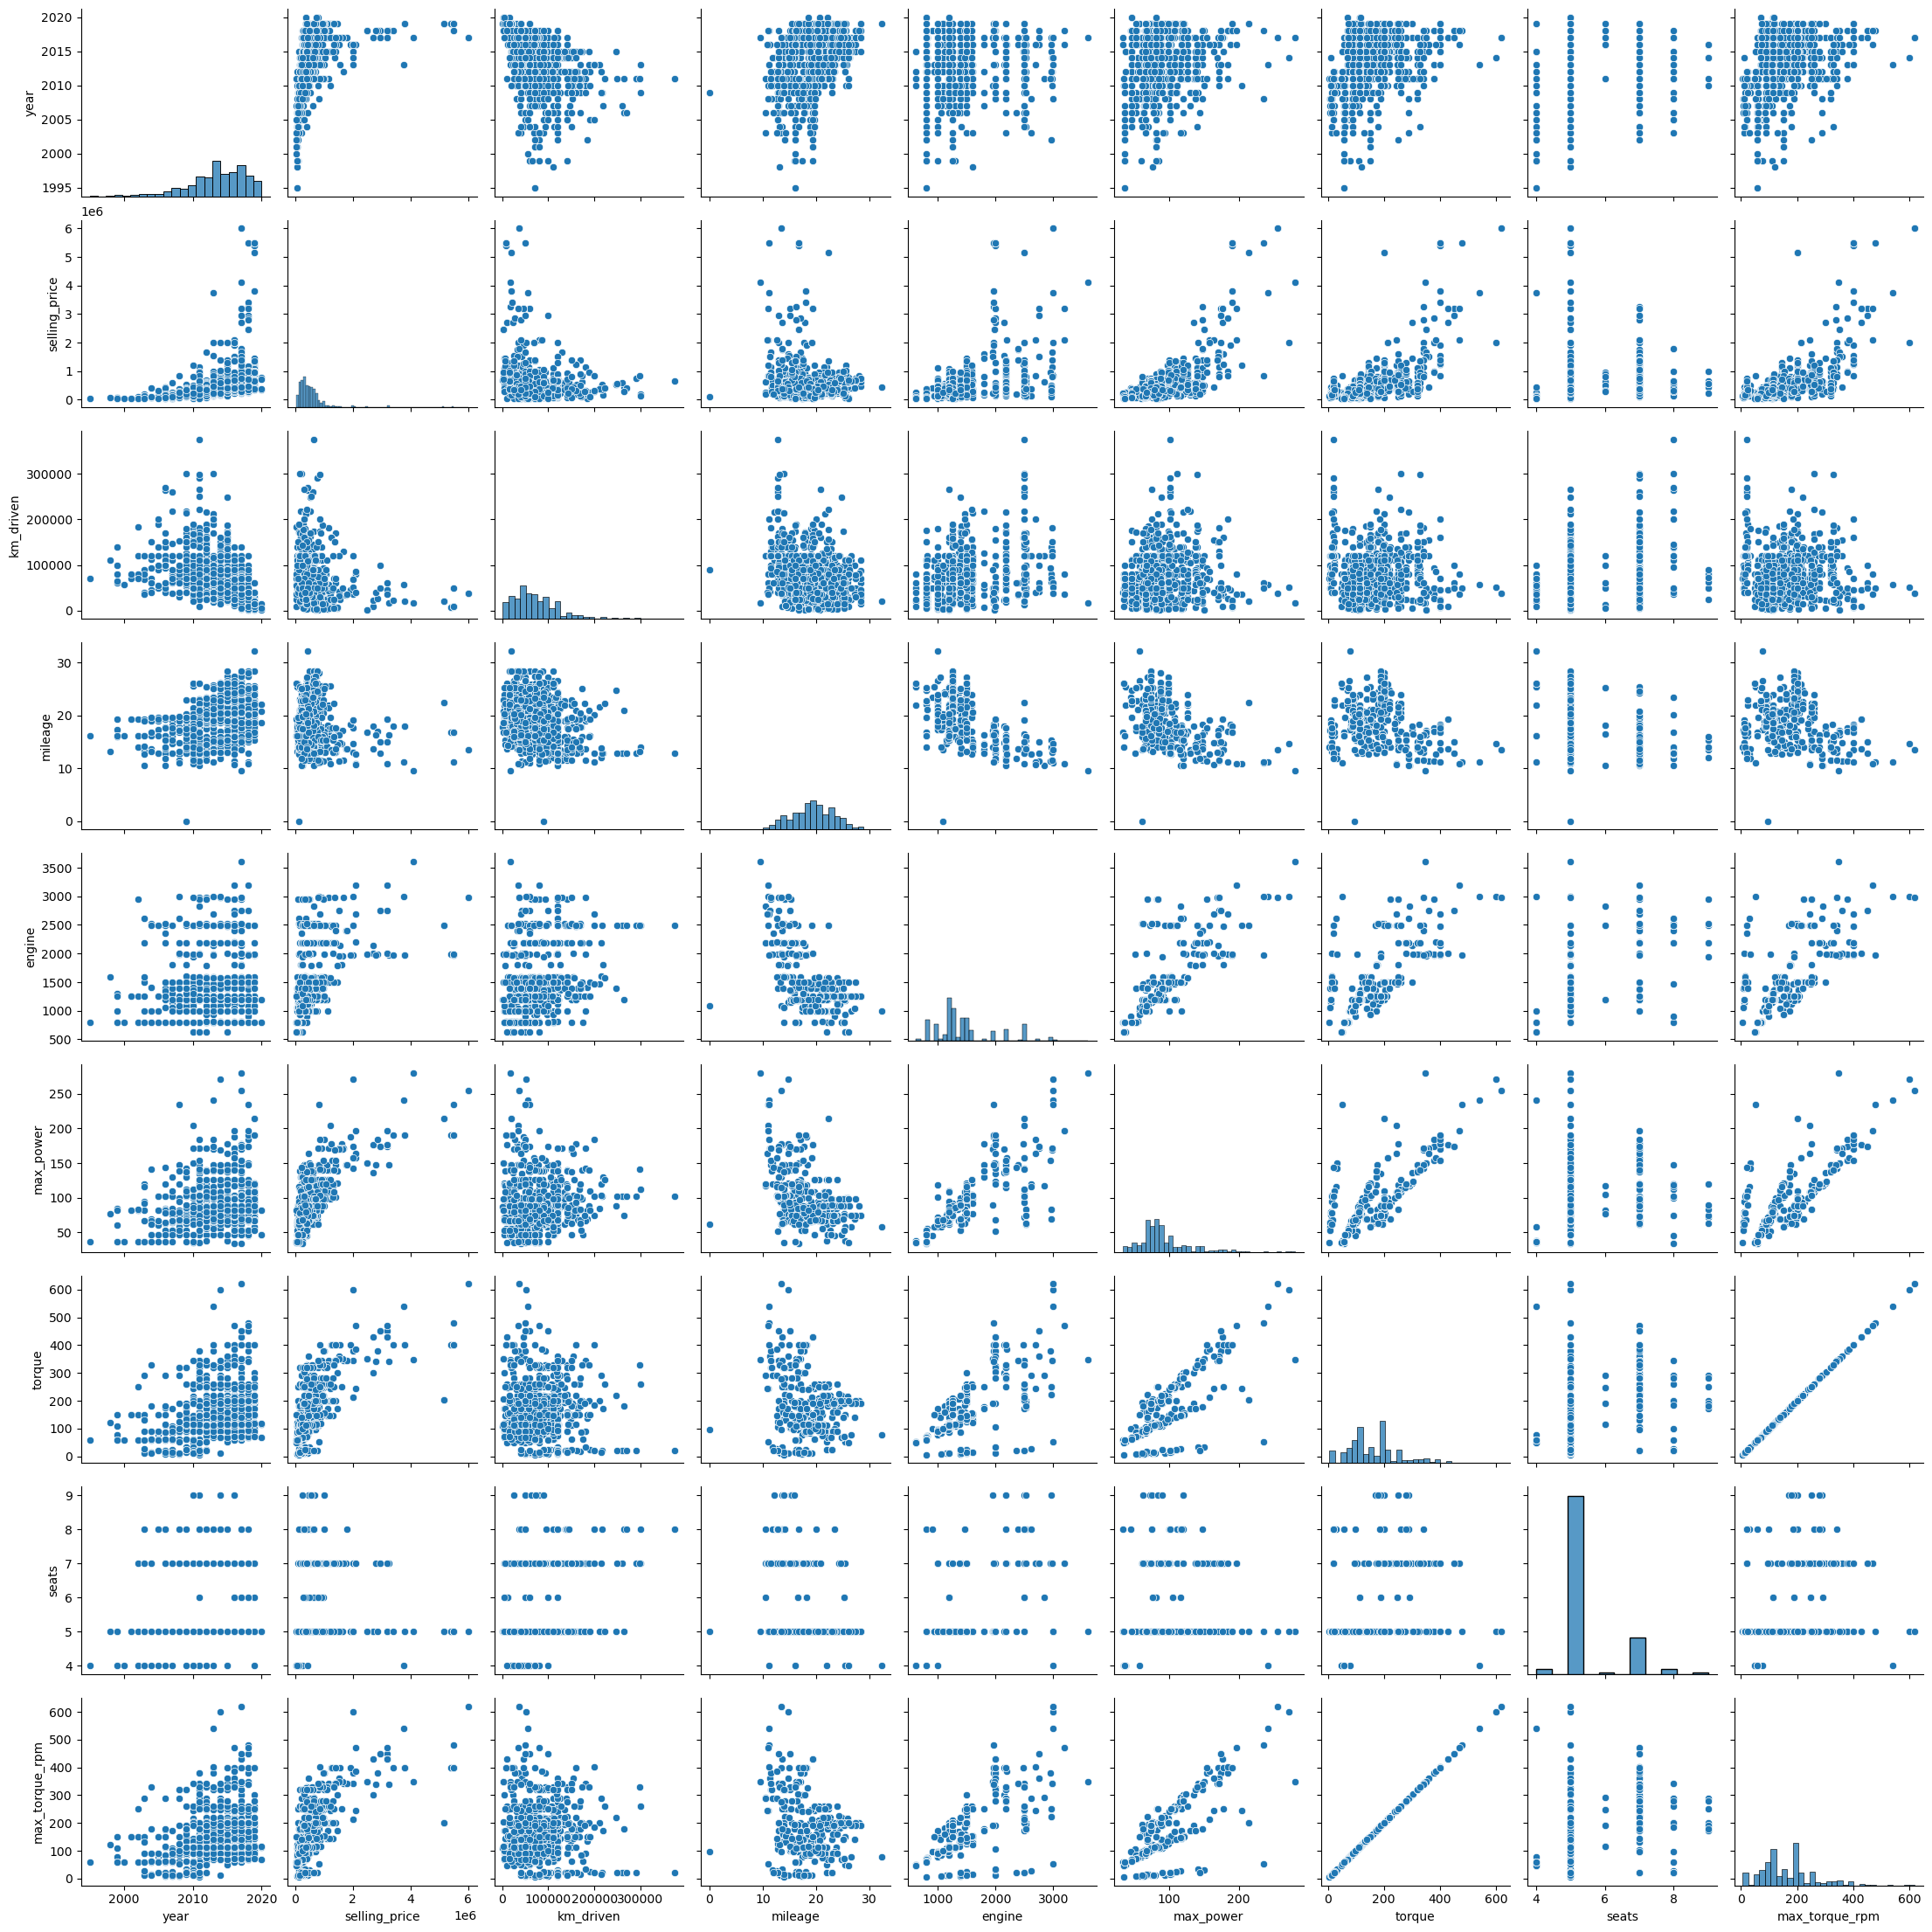

In [251]:
sns.pairplot(df_test)

>  <font color='#0000ff'>Основные выводы о зависимостях, сделанные для трейна, можно сделать и для тестовых данных. </font>

(0.25 балла) <font color='#9933CC'>Для трейна давайте построим тепловую карту (heatmap из библиотеки seaborn) попарных корреляций числовых колонок</font>

In [252]:
NUM_COLUMNS = ['year', 'selling_price', 'km_driven', 'mileage',
'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']

<Axes: >

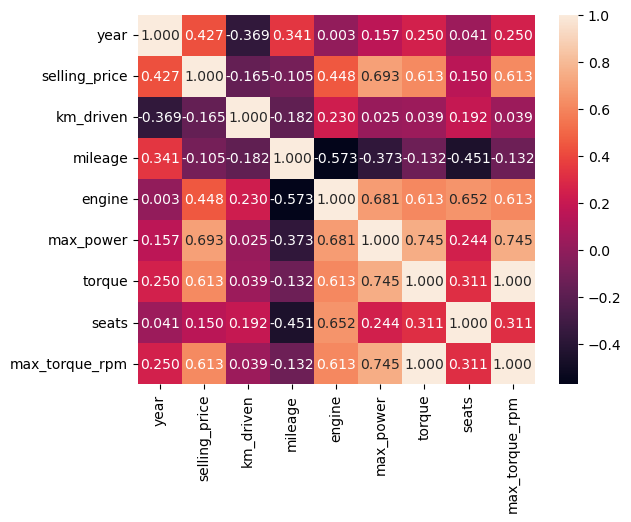

In [253]:
sns.heatmap(df_train[NUM_COLUMNS].corr(), annot = True, fmt=".3f")

Ответьте, пожалуйста, на вопросы: 
* <font color='#FF6600'>Какие 2 признака наименее скоррелированы между собой?</font>

 <font color='#0000ff'>Наименьшую по модулю корреляцию имеет признаки  `year` и  `engine` `(~0.003)`. </font>

* <font color='#FF6600'>Между какими наблюдается довольно сильная положительная линейная зависимость?</font>

>  <font color='#0000ff'>Cильная положительная линейная зависимость (коэффициент корреляции больше 0.6) наблюдается между следующими парами признаков: </font>
* `engine` и `max_power`

* `engine` и `torque`

* `max_power` и  `torque`

* `seats` и  `engine`

>  <font color='#0000ff'>Целевая переменная `selling_price` при этом имеет сильную положительную линейную зависимость с признаками `max_power` и  `torque`.</font>
* <font color='#FF6600'>Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи.</font>


<font color='#0000ff'>В целом да, поскольку между переменными km_driven и year наблюдается слабая отрицательная связь (коэффициент корреляции `-0.369`). Но для более точного ответа на этот вопрос лучше посмотреть на график зависимостей (сделаем это ниже)</font>

<Axes: xlabel='year', ylabel='km_driven'>

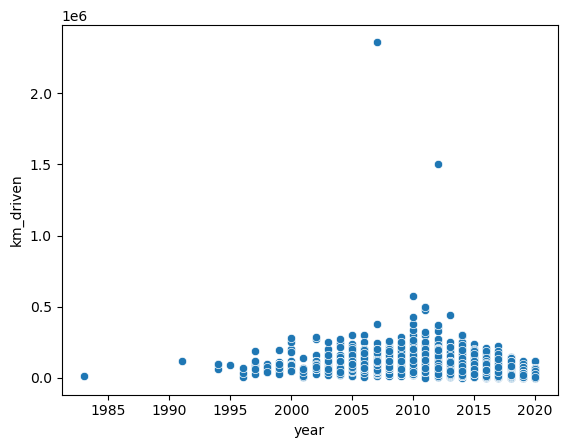

In [85]:
sns.scatterplot(df_train[NUM_COLUMNS], x = 'year', y = 'km_driven')

<font color='#0000ff'>Видно, что зависимость скорее квадратичная, чем линейная, при этом в данных есть два выброса.</font>

(0.25 балла) <font color='#9933CC'> Отобразите диаграммe рассеяния для наиболее скореллированной пары **признаков** (на трейне) </font>

<Axes: xlabel='max_power', ylabel='torque'>

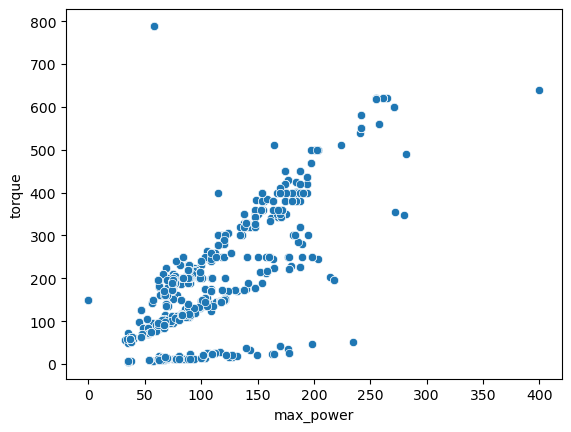

In [254]:
sns.scatterplot(df_train[NUM_COLUMNS], x = 'max_power', y = 'torque')

### Дополнительные визуализации (бонус 0.5 балла)

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

<font color='#0000ff'>Визуализируем следующие зависимости на трейне и тесте:</font>
* `max_power` и `engine`.
* `torque` и `engine`.

 <font color='#0000ff'>Между этими парами признаков прослеживается положительная линейная связь.</font>
 * `max_power` и `selling_price`  <font color='#0000ff'>(только на трейне)</font>
 * `torque` и `selling_price`  <font color='#0000ff'>(только на трейне)</font>
 
 <font color='#0000ff'>На графике видно, что чем больше `max_power`, тем, скорее всего, больше цена продажи.</font>

Text(0.5, 1.0, 'torque vs selling_price (train)')

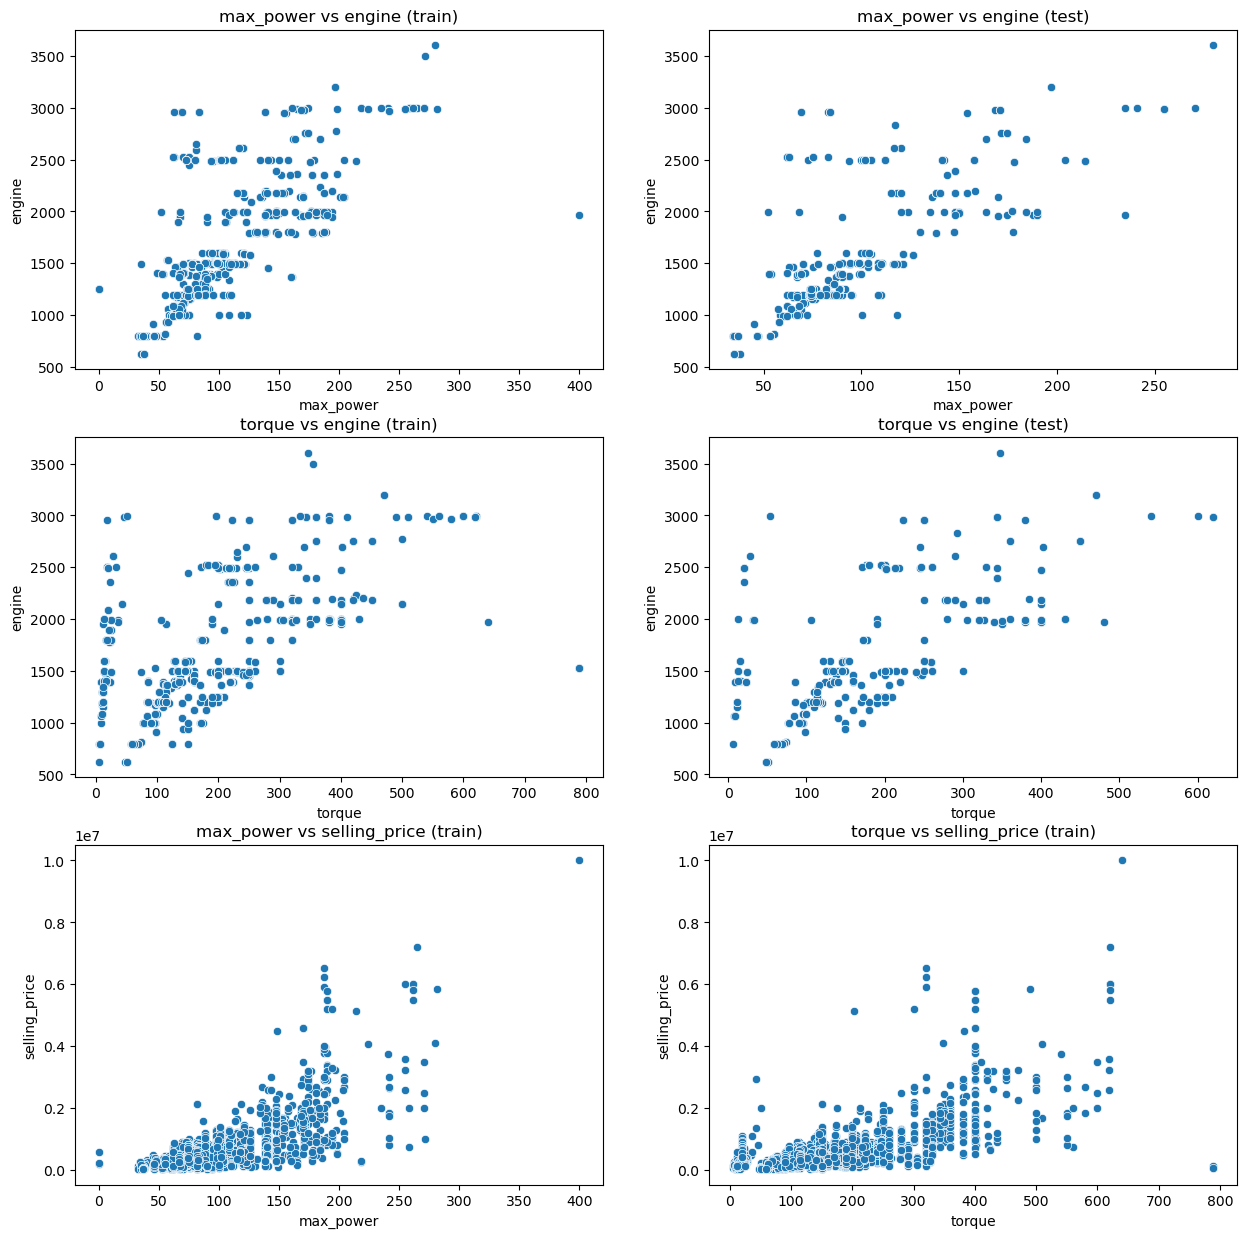

In [258]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize = (15, 15))
sns.scatterplot(df_train[NUM_COLUMNS], x = 'max_power', y = 'engine', ax=ax1[0])
sns.scatterplot(df_train[NUM_COLUMNS], x = 'torque', y = 'engine',  ax=ax2[0])
sns.scatterplot(df_train[NUM_COLUMNS], x = 'max_power', y = 'selling_price', ax=ax3[0])
sns.scatterplot(df_test[NUM_COLUMNS], x = 'max_power', y = 'engine', ax=ax1[1])
sns.scatterplot(df_test[NUM_COLUMNS], x = 'torque', y = 'engine',  ax=ax2[1])
sns.scatterplot(df_train[NUM_COLUMNS], x = 'torque', y = 'selling_price', ax=ax3[1])
ax1[0].set_title('max_power vs engine (train)')
ax2[0].set_title('torque vs engine (train)')
ax3[0].set_title('max_power vs selling_price (train)')

ax1[1].set_title('max_power vs engine (test)')
ax2[1].set_title('torque vs engine (test)')
ax3[1].set_title('torque vs selling_price (train)')

 <font color='#0000ff'>Построим boxplot переменной `selling_price`, а также её распределение. </font>

Text(0.5, 1.0, 'selling price distribution')

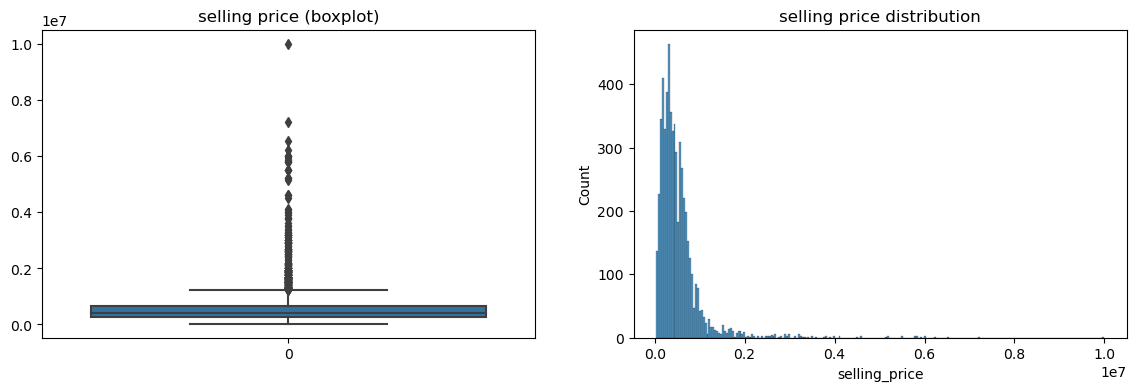

In [259]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))
sns.boxplot(df_train['selling_price'], ax=ax1)
sns.histplot(df_train['selling_price'], ax=ax2)
ax1.set_title('selling price (boxplot)')
ax2.set_title('selling price distribution')

 <font color='#0000ff'>Видим, что распределение не нормальное и что есть несколько машин с очень высоким значением цены. Нарисуем графики без них: </font>

Text(0.5, 1.0, 'selling price distribution')

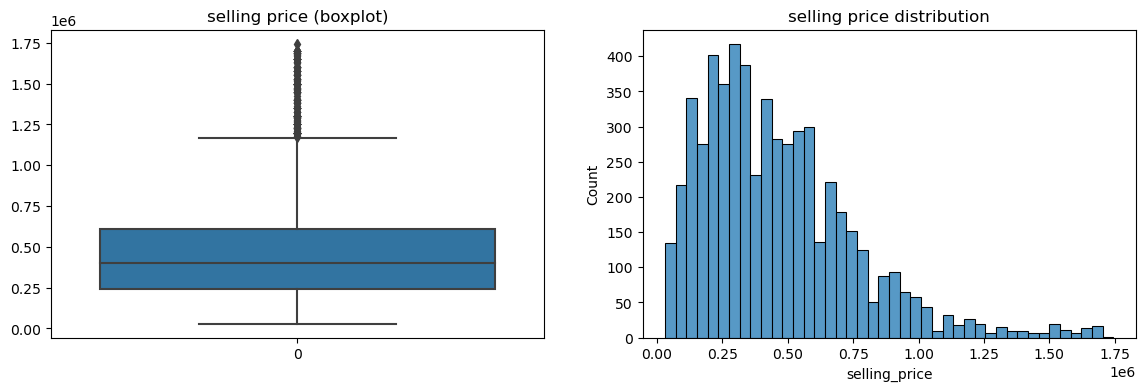

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))
qn = df_train['selling_price'].quantile(0.975)
sns.boxplot(df_train[df_train['selling_price'] < qn]['selling_price'], ax=ax1)
sns.histplot(df_train[df_train['selling_price'] < qn]['selling_price'], ax=ax2)
ax1.set_title('selling price (boxplot)')
ax2.set_title('selling price distribution')

 <font color='#0000ff'>Построим распределения всех числовых переменных: </font>

In [271]:
axes.shape

(4, 3)

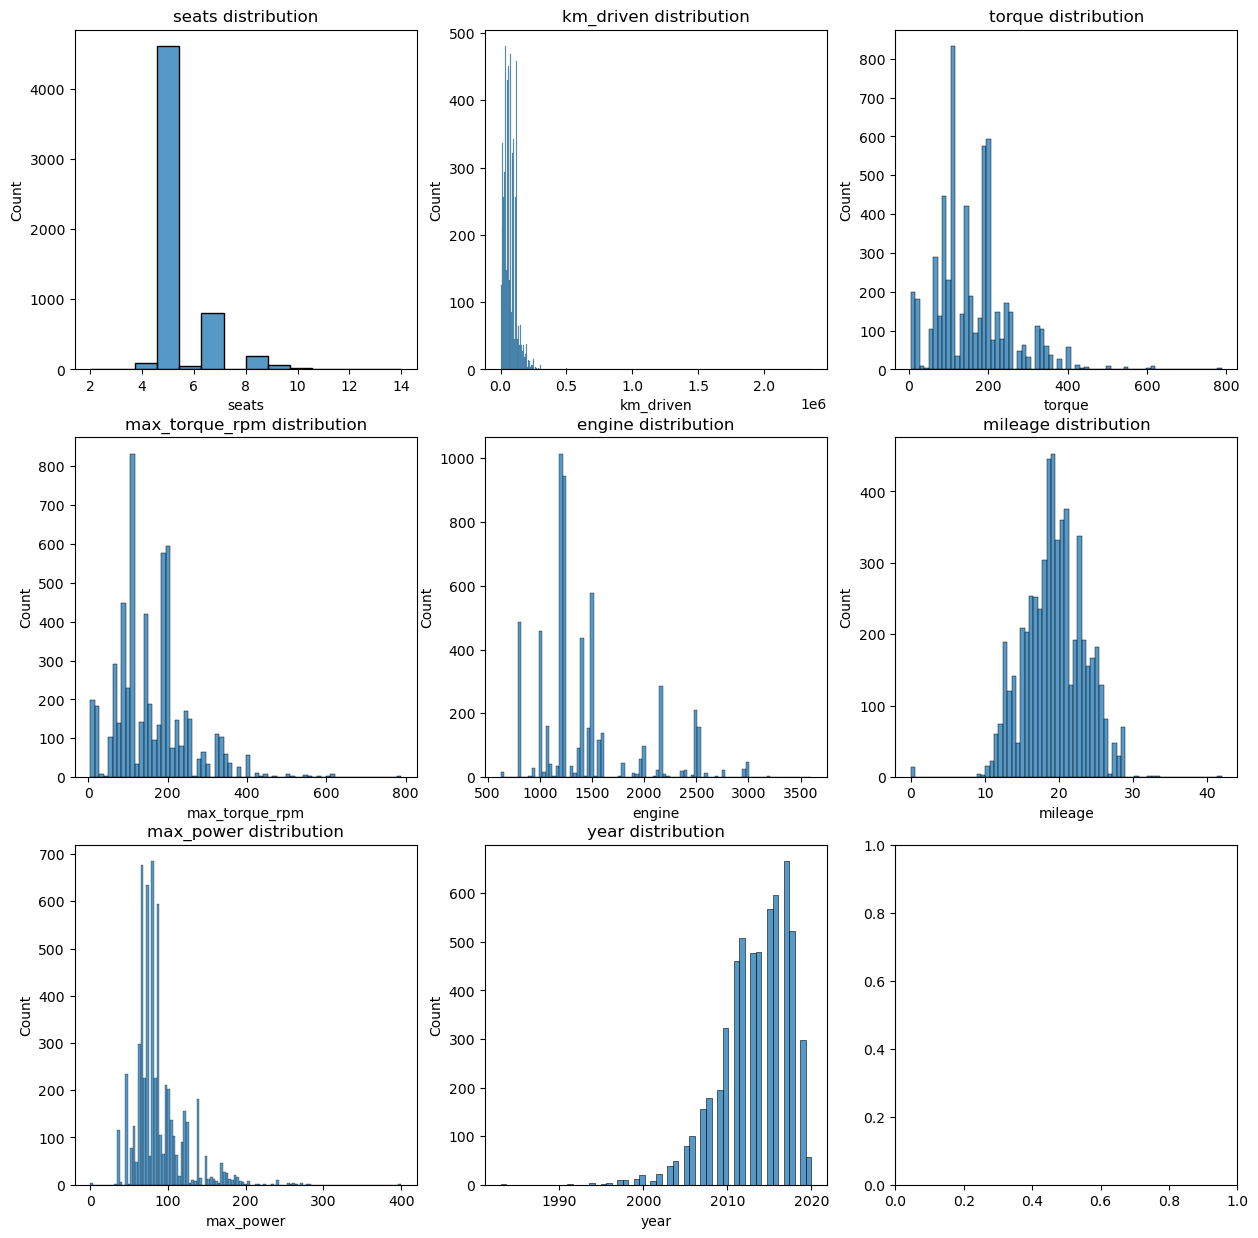

In [285]:
fig, axes = plt.subplots(int(math.sqrt(len(NUM_COLUMNS))), int(math.sqrt(len(NUM_COLUMNS))), figsize = (15, 15))
for ind, column in enumerate(set(NUM_COLUMNS) - {'selling_price'}):
    i, j = ind // axes.shape[0], ind % axes.shape[0]
    sns.histplot(df_train[column], ax=axes[i][j])
    axes[i][j].set_title(f'{column} distribution')

# Часть 2 (1.25 балла) | Модель только на вещественных признаках

(0.05 балла) <font color='#9933CC'>В переменные ``y_train`` и ``y_test`` запишите значения целевых переменных. Столбцы ``selling_price`` из датафреймов необходимо удалить. Категориальные (все, кроме ``seats``) столбцы тоже.</font>

In [286]:
y_train = df_train['selling_price']
X_train = df_train[NUM_COLUMNS].drop('selling_price', axis=1)

In [287]:
#assert X_train.shape == (5840, 6) # для нас не сработает, т.к. мы не удаляли torque; останется 8 столбцов
X_train.shape

(5840, 8)

In [288]:
y_test = df_test['selling_price']
X_test = df_test[NUM_COLUMNS].drop('selling_price', axis=1)

In [289]:
#assert X_test.shape == (1000, 6)
X_test.shape

(1000, 8)

(0.2 балла) <font color='#9933CC'>Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и MSE для трейна и для теста</font>

**Замечание:** $R^2$ и MSE для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [326]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train1 = lr.predict(X_train)
y_pred_test1 = lr.predict(X_test)
print(f'R2, train: {r2_score(y_train, y_pred_train1)}')
print(f'R2, test: {r2_score(y_test, y_pred_test1)}')
print(f'MSE, train: {MSE(y_train, y_pred_train1)}')
print(f'MSE, test: {MSE(y_test, y_pred_test1)}')

R2, train: 0.5985024878113849
R2, test: 0.5989860292246376
MSE, train: 115084579748.56995
MSE, test: 230514281611.6389


Запомните правило:

> Использую линейную модель -- стандартизирую фичи

(0.25 балла) <font color='#9933CC'>Воспользуемся им</font>


In [329]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

lr_for_standard = LinearRegression()
lr_for_standard.fit(X_train_standard, y_train)
y_pred_train2 = lr_for_standard.predict(X_train_standard)
y_pred_test2 = lr_for_standard.predict(X_test_standard)
print(f'R2, train (norm features): {r2_score(y_train, y_pred_train2)}')
print(f'R2, test (norm features): {r2_score(y_test, y_pred_test2)}')
print(f'MSE, train (norm features): {MSE(y_train, y_pred_train2)}')
print(f'MSE, test (norm features): {MSE(y_test, y_pred_test2)}')

R2, train (norm features): 0.5985024878113852
R2, test (norm features): 0.5989860292246436
MSE, train (norm features): 115084579748.56987
MSE, test (norm features): 230514281611.6355


Не очень результативно.

Зато уже сейчас можем интерпретировать модель. <font color='#FF6600'>"Какой признак оказался наиболее информативным в предсказании цены?"</font>

In [333]:
sorted(dict(zip(X_train.columns, lr_for_standard.coef_)).items(), key = lambda x: x[1])

[('km_driven', -44942.46117281221),
 ('seats', -30285.741040555247),
 ('mileage', 7703.106478469188),
 ('torque', 35634.93293002103),
 ('max_torque_rpm', 35634.93293002108),
 ('engine', 40650.82151982683),
 ('year', 149230.8900000372),
 ('max_power', 278130.07969853486)]

 <font color='#0000ff'>Наиболее информативным оказался признак `max_power`. </font>

(0.25 балла) <font color='#9933CC'>Теперь попробуем Lasso-регрессию.</font> Здесь и дальше обучайте модели на нормализованных признаках

In [335]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train_standard, y_train)
y_pred_train3 = lasso.predict(X_train_standard)
y_pred_test3 = lasso.predict(X_test_standard)
print(f'R2, train (norm features, Lasso): {r2_score(y_train, y_pred_train3)}')
print(f'R2, test (norm features, Lasso): {r2_score(y_test, y_pred_test3)}')
print(f'MSE, train (norm features, Lasso): {MSE(y_train, y_pred_train3)}')
print(f'MSE, test (norm features, Lasso): {MSE(y_test, y_pred_test3)}')

R2, train (norm features, Lasso): 0.5985024877856582
R2, test (norm features, Lasso): 0.5989848889922315
MSE, train (norm features, Lasso): 115084579755.9442
MSE, test (norm features, Lasso): 230514937049.78604


<font color='#FF6600'>Занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Почему же?</font>

In [336]:
lasso.coef_

array([149230.7615521 , -44941.48585582,   7701.3440876 ,  40647.15966686,
       278130.24108759,  61864.28701132, -30283.44013082,   9405.74752603])

 <font color='#0000ff'>Нет, никакие признаки не занулились. Это связано с маленьким значением параметра регуляризации (по умолчанию `alpha=1`) </font>

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии</font>

Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [366]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(np.log(0.01), np.log(1000), 1000)}
lasso2 = Lasso()
grid_search = GridSearchCV(estimator=lasso2, param_grid=param_grid, cv=10)
grid_search.fit(X_train_standard, y_train)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': array([2.48216024e-05, 2.54890861e-05, 2.61745193e-05, 2.68783846e-05,
       2.76011777e-05, 2.83434077e-05, 2.91055971e-05, 2.98882828e-05,
       3.06920158e-05, 3.15173622e-05, 3.23649033e-05, 3.32352357e-05,
       3.41289725e-05, 3.50467429e-05, 3.59891934e-05, 3.69569875e-05,
       3.79508068e-05, 3.89713511e-05, 4.00193391e-05, 4...
       4.39230946e+06, 4.51042412e+06, 4.63171503e+06, 4.75626759e+06,
       4.88416954e+06, 5.01551092e+06, 5.15038424e+06, 5.28888447e+06,
       5.43110914e+06, 5.57715841e+06, 5.72713513e+06, 5.88114490e+06,
       6.03929619e+06, 6.20170037e+06, 6.36847180e+06, 6.53972791e+06,
       6.71558932e+06, 6.89617985e+06, 7.08162670e+06, 7.27206043e+06,
       7.46761517e+06, 7.66842862e+06, 7.87464219e+06, 8.08640109e+06])})

In [367]:
best_alpha = grid_search.best_params_['alpha']
best_alpha 

26915.258007387067

<font color='#FF6600'>Сколько грид-сёрчу пришлось обучать моделей?</font>

 <font color='#0000ff'>Грид-сёрч обучал отдельную модель для каждой комбинации параметров и фолда в кросс-валидации. У нас один параметр `alpha` с 1000 возможными значениями и 10 фолдов, поэтому всего мы обучили 10000 моделей. </font>

<font color='#FF6600'>Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?</font>

In [373]:
lasso2 = Lasso(alpha = best_alpha)
lasso2.fit(X_train_standard, y_train)
y_pred_train4 = lasso2.predict(X_train_standard)
y_pred_test4 = lasso2.predict(X_test_standard)
print(f'R2, train (norm features, Lasso): {r2_score(y_train, y_pred_train4)}')
print(f'R2, test (norm features, Lasso): {r2_score(y_test, y_pred_test4)}')
print(f'MSE, train (norm features, Lasso): {MSE(y_train, y_pred_train4)}')
print(f'MSE, test (norm features, Lasso): {MSE(y_test, y_pred_test4)}')

R2, train (norm features, Lasso): 0.5904796753453234
R2, test (norm features, Lasso): 0.5679881838168714
MSE, train (norm features, Lasso): 117384225382.79872
MSE, test (norm features, Lasso): 248332728315.28894


In [374]:
sorted(dict(zip(X_train.columns, lasso2.coef_)).items(), key = lambda x: x[1])

[('km_driven', -20711.095133764837),
 ('mileage', 0.0),
 ('engine', 0.0),
 ('seats', -0.0),
 ('max_torque_rpm', 0.0),
 ('torque', 62257.745628683966),
 ('year', 135191.00133982475),
 ('max_power', 276960.3155749291)]

 <font color='#0000ff'>Лучший коэффициент регуляризации - 26915.26, занулились признаки  `mileage`,  `engine` и  `seats` и `max_torque_rpm`. </font>

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)-регрессии</font>

In [377]:
from sklearn.linear_model import ElasticNet

param_grid = {'alpha':  np.logspace(np.log(1), np.log(1000), 1000), 'l1_ratio' : np.linspace(0.1, 0.9, 5)}
EN = ElasticNet()
grid_search2 = GridSearchCV(estimator=EN, param_grid=param_grid, cv=10)
grid_search2.fit(X_train_standard, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e+00, 1.01604904e+00, 1.03235565e+00, 1.04892397e+00,
       1.06575819e+00, 1.08286259e+00, 1.10024149e+00, 1.11789931e+00,
       1.13584053e+00, 1.15406968e+00, 1.17259139e+00, 1.19141035e+00,
       1.21053135e+00, 1.22995921e+00, 1.24969888e+00, 1.26975534e+00,
       1.29013370e+00, 1.31083911e+00, 1.33187682e...
       5.60683622e+06, 5.69682056e+06, 5.78824906e+06, 5.88114490e+06,
       5.97553164e+06, 6.07143318e+06, 6.16887386e+06, 6.26787836e+06,
       6.36847180e+06, 6.47067966e+06, 6.57452785e+06, 6.68004272e+06,
       6.78725099e+06, 6.89617985e+06, 7.00685692e+06, 7.11931025e+06,
       7.23356835e+06, 7.34966018e+06, 7.46761517e+06, 7.58746323e+06,
       7.70923473e+06, 7.83296055e+06, 7.95867205e+06, 8.08640109e+06]),
                         'l1_ratio': array([0.1, 0.3, 0.5, 0.7, 0.9])})

In [378]:
best_alpha_en, best_l1_ratio_en = grid_search2.best_params_['alpha'], grid_search2.best_params_['l1_ratio']

<font color='#FF6600'>Какие гиперпараметры соответствуют лучшей из перебранных моделей?</font>

`alpha=1.25`, `l1_ratio=0.9`

In [379]:
best_alpha_en, best_l1_ratio_en

(1.249698876212473, 0.9)

In [380]:
EN = ElasticNet(alpha = best_alpha_en, l1_ratio = best_l1_ratio_en)
EN.fit(X_train_standard, y_train)
y_pred_train5 = EN.predict(X_train_standard)
y_pred_test5 = EN.predict(X_test_standard)
print(f'R2, train (norm features, ElasticNet): {r2_score(y_train, y_pred_train5)}')
print(f'R2, test (norm features, ElasticNet): {r2_score(y_test, y_pred_test5)}')
print(f'MSE, train (norm features, ElasticNet): {MSE(y_train, y_pred_train5)}')
print(f'MSE, test (norm features, ElasticNet): {MSE(y_test, y_pred_test5)}')

R2, train (norm features, ElasticNet): 0.5930213515391456
R2, test (norm features, ElasticNet): 0.5768345630065805
MSE, train (norm features, ElasticNet): 116655683541.95775
MSE, test (norm features, ElasticNet): 243247576943.0384


Предлагаем вам оставить вам попытки заметно улучшить качество модели регуляризацией и перейти к следующей части задания.

# Часть 3 (0.5 балла) | Добавляем категориальные фичи



(0 баллов) <font color='#9933CC'>Из ``df_train`` удалите столбцы с целевой переменной и названием автомобиля.</font>

In [381]:
X_train_cat = df_train.drop(['selling_price', 'name'], axis=1)

In [382]:
#assert X_train_cat.shape == (5840, 10)
X_train_cat.shape

(5840, 12)

(0.5 балла) <font color='#9933CC'>Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования</font>

> Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot. 

In [383]:
X_train_cat = df_train.drop(['selling_price', 'name'], axis=1)
X_train_cat['seats'] = X_train_cat['seats'].astype(int).astype(str)
X_train_cat = pd.get_dummies(X_train_cat, drop_first = True)
X_train_cat.head()

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,fuel_Diesel,fuel_LPG,fuel_Petrol,...,owner_Test Drive Car,owner_Third Owner,seats_14,seats_2,seats_4,seats_5,seats_6,seats_7,seats_8,seats_9
0,2014,145500,23.4000,1248,74.0000,190.0000,190.0000,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2014,120000,21.1400,1498,103.5200,250.0000,250.0000,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2010,127000,23.0000,1396,90.0000,22.4000,22.4000,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2007,120000,16.1000,1298,88.2000,11.5000,11.5000,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,2017,45000,20.1400,1197,81.8600,113.7500,113.7500,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [384]:
X_test_cat = df_test.drop(['selling_price', 'name'], axis=1)
X_test_cat['seats'] = X_test_cat['seats'].astype(int).astype(str)
X_test_cat = pd.get_dummies(X_test_cat, drop_first = True)
X_test_cat.head()

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,fuel_Diesel,fuel_LPG,fuel_Petrol,...,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,seats_5,seats_6,seats_7,seats_8,seats_9
0,2010,168000,14.0000,2498.0000,112.0000,260.0000,260.0000,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,2017,25000,21.5000,1497.0000,108.5000,260.0000,260.0000,1,0,0,...,1,0,0,0,0,1,0,0,0,0
2,2007,218463,12.9000,1799.0000,130.0000,172.0000,172.0000,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,2015,173000,25.1000,1498.0000,98.6000,200.0000,200.0000,1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2011,70000,16.5000,1172.0000,65.0000,96.0000,96.0000,0,0,1,...,1,0,1,0,0,1,0,0,0,0


Посмотрим на отличие набора столбцов в трейне и тесте:

In [385]:
set(X_train_cat) - set(X_test_cat)

{'seats_14', 'seats_2', 'seats_4'}

Добавим в тест соответствующие столбцы со значением 0 и упорядочим столбцы:

In [386]:
for col in set(X_train_cat) - set(X_test_cat):
    X_test_cat[col] = 0

In [387]:
X_test_cat = X_test_cat[X_train_cat.columns]

(0.25 балла) <font color='#9933CC'>Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV`.</font> В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.

<font color='#FF6600'>Удалось ли улучшить качество предсказаний?</font>

In [390]:
from sklearn.linear_model import Ridge

scaler = StandardScaler()
scaler.fit(X_train_cat)
X_train_cat_norm = scaler.transform(X_train_cat)
X_test_cat_norm = scaler.transform(X_test_cat)

param_grid = {'alpha': np.logspace(np.log(1), np.log(1000), 1000)}
ridge = Ridge()
grid_search2 = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=10, scoring = 'r2')
grid_search2.fit(X_train_cat_norm, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e+00, 1.01604904e+00, 1.03235565e+00, 1.04892397e+00,
       1.06575819e+00, 1.08286259e+00, 1.10024149e+00, 1.11789931e+00,
       1.13584053e+00, 1.15406968e+00, 1.17259139e+00, 1.19141035e+00,
       1.21053135e+00, 1.22995921e+00, 1.24969888e+00, 1.26975534e+00,
       1.29013370e+00, 1.31083911e+00, 1.33187682e+00, 1...
       5.60683622e+06, 5.69682056e+06, 5.78824906e+06, 5.88114490e+06,
       5.97553164e+06, 6.07143318e+06, 6.16887386e+06, 6.26787836e+06,
       6.36847180e+06, 6.47067966e+06, 6.57452785e+06, 6.68004272e+06,
       6.78725099e+06, 6.89617985e+06, 7.00685692e+06, 7.11931025e+06,
       7.23356835e+06, 7.34966018e+06, 7.46761517e+06, 7.58746323e+06,
       7.70923473e+06, 7.83296055e+06, 7.95867205e+06, 8.08640109e+06])},
             scoring='r2')

In [391]:
best_alpha_ridge = grid_search2.best_params_['alpha']
best_alpha_ridge

538.6350741484617

In [392]:
y_pred_train5 = grid_search2.predict(X_train_cat_norm)
y_pred_test5 = grid_search2.predict(X_test_cat_norm)
print(f'R2, train (norm features, Ridge): {r2_score(y_train, y_pred_train5)}')
print(f'R2, test (norm features, Ridge): {r2_score(y_test, y_pred_test5)}')
print(f'MSE, train (norm features, Ridge): {MSE(y_train, y_pred_train5)}')
print(f'MSE, test (norm features, Ridge): {MSE(y_test, y_pred_test5)}')

R2, train (norm features, Ridge): 0.6665201969333082
R2, test (norm features, Ridge): 0.6155712089112624
MSE, train (norm features, Ridge): 95588096626.95178
MSE, test (norm features, Ridge): 220980646727.3723


Судя по метрике $R^2$, качество немного увеличилось.

# Часть 4 - бонусная (1.5 балла) | Feature Engineering 

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

 <font color='#0000ff'>Чтоб не дублировать код, напишем функцию препроцессинга, а также функцию обучения модели.</font>

 <font color='#0000ff'>Чтобы иметь представление о том, что именно помогло и как, будем каждый раз вносить не более одного изменения. При этом будем считать как R2, так и бизнес-метрику из следующего пункта.</font>

In [475]:
df_train = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_test.csv')

In [454]:
def str_to_float(st):
    if isinstance(st, float) or st is None:
        return st
    num = re.findall('\d+[.,]?\d*', st)
    if len(num) == 0:
        return np.nan
    else:
        return float(num[0])

In [455]:
y_train = df_train['selling_price']
y_test = df_test['selling_price']
for col in ('mileage', 'engine', 'max_power'):
    df_train[f'{col}'] = df_train[col].apply(str_to_float)
    df_test[f'{col}'] = df_test[col].apply(str_to_float)
df_train['tmp_torque'] = df_train['torque'].apply(divide_torque)
df_train['torque'] = df_train['tmp_torque'].apply(lambda x: x[0])
df_train['max_torque_rpm'] = df_train['tmp_torque'].apply(lambda x: x[1])
df_train = df_train.drop('tmp_torque', axis=1)
    
df_test['tmp_torque'] = df_test['torque'].apply(divide_torque)
df_test['torque'] = df_test['tmp_torque'].apply(lambda x: x[0])
df_test['max_torque_rpm'] = df_test['tmp_torque'].apply(lambda x: x[1])
df_test = df_test.drop('tmp_torque', axis=1)
for column in ('mileage', 'engine', 'max_power', 'torque' , 'max_torque_rpm', 'seats'):
    train_median = df_train[column].median()
    df_train[column] = df_train[column].fillna(train_median)
    df_test[column] = df_test[column].fillna(train_median)

In [466]:
def prepare_data_for_fitting(df_train, df_test, columns_for_drop, is_save_add_data = False):
    X_train_cat = df_train.drop(columns_for_drop, axis=1)
    X_train_cat['seats'] = X_train_cat['seats'].astype(int).astype(str)
    X_train_cat = pd.get_dummies(X_train_cat, drop_first = True)
    X_test_cat = df_test.drop(columns_for_drop, axis=1)
    X_test_cat['seats'] = X_test_cat['seats'].astype(int).astype(str)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first = True)
    for col in set(X_train_cat) - set(X_test_cat):
        X_test_cat[col] = 0
    X_test_cat = X_test_cat[X_train_cat.columns]
    scaler = StandardScaler()
    scaler.fit(X_train_cat)
    X_train_cat_norm = scaler.transform(X_train_cat)
    X_test_cat_norm = scaler.transform(X_test_cat)
    if is_save_add_data:
        medians_train = {}
        for column in ('mileage', 'engine', 'max_power', 'torque' , 'max_torque_rpm', 'seats'):
            medians_train[column] = df_train[column].median()
        with open('add_data.pkl', 'wb') as file:
            pickle.dump({'scaler' : scaler, 'medians_train' : medians_train, 'train_columns' : X_train_cat.columns}, file)
    return  X_train_cat_norm, y_train, X_test_cat_norm 

def business_metrics(y_true, y_pred):
    good_predicts = 0
    for i in range(len(y_true)):
         if y_true[i] * 0.9 <= y_pred[i] <= y_true[i] * 1.1:
            good_predicts += 1
    return  good_predicts / len(y_true)

def model_fit_predict_estimate(X_train_cat_norm, y_train, X_test_cat_norm, y_test, model, description,
                               is_log_target = False, is_save_model = False):
    if is_log_target:
        model.fit(X_train_cat_norm, y_train.apply(math.log))
    else:
        model.fit(X_train_cat_norm, y_train)
    if is_save_model:
        with open('model.pkl', 'wb') as file:
            pickle.dump({'model': final_model}, file)
    y_pred_train =  model.predict(X_train_cat_norm)
    y_pred_test =  model.predict(X_test_cat_norm)
    if is_log_target:
        y_pred_train = list(map(math.exp, y_pred_train))
        y_pred_test = list(map(math.exp, y_pred_test))
    print(f'R2, train ({description}): {r2_score(y_train, y_pred_train)}')
    print(f'R2, test ({description}): {r2_score(y_test, y_pred_test)}')
    print(f'MSE, train ({description}): {MSE(y_train, y_pred_train)}')
    print(f'MSE, test ({description}): {MSE(y_test, y_pred_test)}')
    print(f'Business metric, train ({description}): {business_metrics(y_train, y_pred_train)}')
    print(f'Business metric, test ({description}): {business_metrics(y_test, y_pred_test)}')
    

 <font color='#0000ff'>По результатам визуализации можно увидеть, что распределение как целевой, так и некоторых независимых числовых переменных не нормальное, и слишком большие значения могут серьезно влиять на прогноз. Начнем с логарифмирования целевой переменной. </font>

In [457]:
X_train_cat_norm, y_train, X_test_cat_norm  = prepare_data_for_fitting(df_train, df_test, ['selling_price', 'name'])
model = LinearRegression()
model_fit_predict_estimate(X_train_cat_norm, y_train, X_test_cat_norm, y_test, model, description = 'model1', is_log_target = True)

R2, train (model1): 0.8381317895680513
R2, test (model1): 0.8583703018482738
MSE, train (model1): 105909321120.87637
MSE, test (model1): 81412794824.06564
Business metric, train (model1): 0.27946849549935704
Business metric, test (model1): 0.268


 <font color='#0000ff'>Используем советы из задания.
Заменим year на его квадрат.</font>

In [458]:
df_train['year_2'] = df_train['year'] ** 2
df_test['year_2'] = df_test['year'] ** 2
X_train_cat_norm, y_train, X_test_cat_norm  = prepare_data_for_fitting(df_train, df_test, ['selling_price', 'name', 'year'])
model2 = LinearRegression()
model_fit_predict_estimate(X_train_cat_norm, y_train, X_test_cat_norm, y_test, model2, description = 'model1', is_log_target = True)

R2, train (model1): 0.8384800394671161
R2, test (model1): 0.85854018279468
MSE, train (model1): 105681463468.704
MSE, test (model1): 81315142405.01242
Business metric, train (model1): 0.27946849549935704
Business metric, test (model1): 0.268


Вытащим модель автомобиля из name:

In [459]:
df_train['model'] = df_train['name'].apply(lambda x: x.split()[0])
df_test['model'] = df_test['name'].apply(lambda x: x.split()[0])
X_train_cat_norm, y_train, X_test_cat_norm  = prepare_data_for_fitting(df_train, df_test, ['selling_price', 'name', 'year'])
model3 = LinearRegression()
model_fit_predict_estimate(X_train_cat_norm, y_train, X_test_cat_norm, y_test, model3, description = 'model3', is_log_target = True)


R2, train (model3): 0.9350625547852836
R2, test (model3): 0.927791959366961
MSE, train (model3): 42488149585.77735
MSE, test (model3): 41507243702.57189
Business metric, train (model3): 0.34833547649664237
Business metric, test (model3): 0.357


 <font color='#0000ff'>Логарифмируем другие переменные: </font>

In [460]:
df_train['km_driven_log'] = df_train['km_driven'].apply(math.log)
df_test['km_driven_log'] = df_test['km_driven'].apply(math.log)
X_train_cat_norm, y_train, X_test_cat_norm  = prepare_data_for_fitting(df_train, df_test, ['selling_price', 'name', 'year', 'km_driven'])
model4 = LinearRegression()
model_fit_predict_estimate(X_train_cat_norm, y_train, X_test_cat_norm, y_test, model4, description = 'model4', is_log_target = True)


R2, train (model4): 0.9347465399708205
R2, test (model4): 0.927541464639347
MSE, train (model4): 42694916030.98988
MSE, test (model4): 41651235225.04137
Business metric, train (model4): 0.3411915987998285
Business metric, test (model4): 0.338


In [461]:
df_train['max_torque_rpm_log'] = df_train['max_torque_rpm'].apply(math.log)
df_test['max_torque_rpm_log'] = df_test['max_torque_rpm'].apply(math.log)
X_train_cat_norm, y_train, X_test_cat_norm  = prepare_data_for_fitting(df_train, df_test, ['selling_price', 'name',
                                                                                            'year', 'km_driven', 'max_torque_rpm'])
model5 = LinearRegression()
model_fit_predict_estimate(X_train_cat_norm, y_train, X_test_cat_norm, y_test, model5, description = 'model5', is_log_target = True)


R2, train (model5): 0.9345306683743884
R2, test (model5): 0.9272583220361851
MSE, train (model5): 42836159417.609055
MSE, test (model5): 41813993678.65659
Business metric, train (model5): 0.33519074153450495
Business metric, test (model5): 0.337


In [468]:
df_train['engine_log'] = df_train['engine'].apply(math.log)
df_test['engine_log'] = df_test['engine'].apply(math.log)
X_train_cat_norm, y_train, X_test_cat_norm  = prepare_data_for_fitting(df_train, df_test, 
                                                                       ['selling_price', 'name', 'year', 'km_driven', 'max_torque_rpm', 'engine'], is_save_add_data = True)
final_model = LinearRegression()
model_fit_predict_estimate(X_train_cat_norm, y_train, X_test_cat_norm, y_test, final_model, description = 'model6',
                           is_log_target = True, is_save_model=True) #сохраняем финальную модель


R2, train (model6): 0.9405237520560686
R2, test (model6): 0.9318112793424933
MSE, train (model6): 38914923602.0429
MSE, test (model6): 39196823806.38791
Business metric, train (model6): 0.3469067009572796
Business metric, test (model6): 0.355


# Часть Бизнесовая (0.5 балла)

Заказчик просил вас посчитать кастомную метрику -- среди всех предсказанных цен на авто посчитать долю предиктов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

<font color='#9933CC'>Сделайте это самостоятельно для лучшей из своих моделей</font>

In [470]:
def business_metrics(y_true, y_pred):
    good_predicts = 0
    for i in range(len(y_true)):
        if y_true[i] * 0.9 <= y_pred[i] <= y_true[i] * 1.1:
            good_predicts += 1
    return  good_predicts / len(y_true)

X_train_cat_norm, y_train, X_test_cat_norm  = prepare_data_for_fitting(df_train, df_test, 
                                                                       ['selling_price', 'name', 'year', 'km_driven', 'max_torque_rpm', 'engine'])
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)
y_test_pred = list(map(math.exp, model_loaded['model'].predict(X_test_cat_norm)))
print(business_metrics(y_test, y_test_pred))

0.355


# Часть 5 (2.5 балла) | Реализация сервиса на FastAPI

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

Сохраняем в единый pickle файл веса модели, информацию scaler-a, структуру данных на трейне, медианы трейна

In [471]:
with open('model.pkl', 'rb') as file:
    model= pickle.load(file)
    
with open('add_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [472]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump({'model' : model['model'], 'scaler' : data['scaler'], 'medians_train' : data['medians_train'],
                 'train_columns' : data['train_columns']}, file)

In [474]:
from fastapi import FastAPI,  File, UploadFile
from fastapi.responses import StreamingResponse
from pydantic import BaseModel
from typing import List, Union, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re 
import warnings
import math
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
import io

app = FastAPI()

COLUMNS = {'name', 'year',  'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'}
class Item(BaseModel):
    name: str
    year: int
    selling_price: Optional[int] = None
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: Union[str, None]
    engine: Union[str, None]
    max_power: Union[str, None]
    torque: Union[str, None]
    seats: Union[float, None]


class Items(BaseModel):
    objects: List[Item]
        
def str_to_float(st):
    if isinstance(st, float) or st is None:
        return st
    num = re.findall('\d+[.,]?\d*', st)
    if len(num) == 0:
        return np.nan
    else:
        return float(num[0])
    
def divide_torque(torque):
    try:
        if not isinstance(torque, str): #case 1
            final_torque, final_max_torque_rmp = torque, torque
        else:
            torque_split = torque.split('@')
            torque_split_at = torque.split('at')
            torque_split_sl = torque.split('/')
            if len(torque_split) == 2 or len(torque_split) == 3 or len(torque_split_at) == 2 or len(torque_split_sl) == 2: #cases 2, 3, 4, 6
                if len(torque_split) == 2:
                    left, right = torque_split
                elif len(torque_split) == 3:
                    left, right = torque_split[0],  torque_split[1]
                elif len(torque_split_at) == 2:
                    left, right = torque_split_at
                else:
                    left, right = torque_split_sl
                if '+/-' in right:
                    num, interval = re.findall('\d+[.,]?\d*', right)
                    if interval.find(',' ) != -1:
                        interval = interval.replace(',', '')
                    if num.find(',' ) != -1:
                        num = num.replace(',', '')
                    final_max_torque_rmp = float(num) + float(interval) 
                else:
                    num = re.findall('\d+[.,]?\d*', right)[-1]
                    if num.find(',' ) != -1:
                        num = num.replace(',', '')
                    final_max_torque_rmp = float(num)
                num = re.findall('\d+[.,]?\d*', left)[0]
                if num.find(',' ) != -1:
                    num = num.replace(',', '.')
                final_torque = float(num)
            elif len(torque_split) == 1 or len(torque_split) == 1 or len(torque_split_at) == 1 or len(torque_split_sl) == 1: # case 5
                num = re.findall('\d+[.,]?\d*', torque)[0]
                if num.find(',' ) != -1:
                    num = num.replace(',', '.')
                final_torque, final_max_torque_rmp = float(num), np.nan
            else:
                print('!', torque_split, torque_split_at, torque_split_sl)
                final_torque, final_max_torque_rmp = np.nan, np.nan
                warnings.warn(f'Unexpected line structure: {torque}. Returned empty value')
    except:
        final_torque, final_max_torque_rmp = np.nan, np.nan
        warnings.warn(f'Unexpected line structure: {torque}. Returned empty value')
    finally:
        return final_torque, final_max_torque_rmp 

    
def prepare_data_and_get_predict(test):
    df_test = test.copy()
    for col in ('mileage', 'engine', 'max_power'):
        df_test[f'{col}'] = df_test[col].apply(str_to_float)
    df_test['tmp_torque'] = df_test['torque'].apply(divide_torque)
    df_test['torque'] = df_test['tmp_torque'].apply(lambda x: x[0])
    df_test['max_torque_rpm'] = df_test['tmp_torque'].apply(lambda x: x[1])
    df_test = df_test.drop('tmp_torque', axis=1)
    with open('final_model.pkl', 'rb') as file:
        model_loaded = pickle.load(file)
    for column in ('mileage', 'engine', 'max_power', 'torque' , 'max_torque_rpm', 'seats'):
        df_test[column] = df_test[column].fillna(model_loaded['medians_train'][column])
    df_test['max_torque_rpm_log'] = df_test['max_torque_rpm'].apply(math.log) 
    df_test['km_driven_log'] = df_test['km_driven'].apply(math.log) 
    df_test['model'] = df_test['name'].apply(lambda x: x.split()[0])
    df_test['year_2'] = df_test['year'] ** 2
    df_test['engine_log'] = df_test['engine'].astype(int).apply(math.log) 
    X_test_cat = df_test.drop(['selling_price', 'name', 'year', 'max_torque_rpm', 'km_driven', 'engine'], axis=1)
    X_test_cat['seats'] = X_test_cat['seats'].astype(int).astype(str)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first = True)
    for col in set(model_loaded['train_columns']) - set(X_test_cat):
        X_test_cat[col] = 0
    X_test_cat_norm = model_loaded['scaler'].transform(X_test_cat[list(model_loaded['train_columns'])])
    y_pred_test = list(map(math.exp, model_loaded['model'].predict(X_test_cat_norm)))
    return y_pred_test
    
@app.post("/predict_item")
def predict_item(item: Item) -> float:
    df_test = pd.DataFrame([dict(item)])
    y_pred_test = prepare_data_and_get_predict(df_test)
    return y_pred_test[0]


@app.post("/predict_items", response_class=StreamingResponse)
def predict_items(file: UploadFile = File(...)):
    df_test = pd.read_csv(file.file)
    y_pred_test = prepare_data_and_get_predict(df_test)
    stream = io.StringIO()
    df_test['prediction'] = y_pred_test
    df_test.to_csv(stream, index=False)
    response = StreamingResponse(iter([stream.getvalue()]),
                                 media_type="text/csv"
                                )
    return response

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# Часть 6 (1 балл) | Оформление результатов

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете прислать screencast в ТГ
3. Просматривает ноутбук с pure-DS частью
4. Заглядывает в код сервиса
5. Хвалит

# Часть Благодарственная

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

https://drive.google.com/file/d/1LT06nyg9QgVi3r-D5BY-_mQ9TcJQFxJN/view?usp=share_link